![seQuencing logo](../images/sequencing-logo.svg)

# QASM Sequences

A [QasmSequence](../api/classes.rst#QasmSequence) is a subclass of [Sequence](../api/classes.rst#Sequence) which can parse and execute gates specified in [OpenQASM](https://arxiv.org/pdf/1707.03429.pdf) format. `QasmSequence` is conceptually similar to Qiskit's [QuantumCircuit](https://qiskit.org/documentation/apidoc/circuit.html) class (although significantly more limited at this point).

>**Note:** To avoid conflict with the Python builtin name `lambda`, when specifying a variable meant to represent then angle $\lambda$, we intentionally use the misspelling `lamda`. This is inspired by [SymPy](https://docs.sympy.org/latest/tutorial/matrices.html?highlight=lamda).

## Single-qubit gates

`QasmSequence` implements the following single-qubit gates:

- `U(theta, phi, lamda) = u3(theta, phi, lamda)`: $U(\theta,\phi,\lambda) = u_3(\theta,\phi,\lambda) =R_z(\phi)R_y(\theta)R_z(\lambda)$
- `u2(phi, lamda)`: $u_2(\phi,\lambda) = U(\pi/2,\phi,\lambda)$
- `u1(lamda) = rz(lamda) = p(lamda)`: $u_1(\lambda) = R_z(\lambda) = p(\lambda) = U(0,0,\lambda)$
- `id`: $I = U(0,0,0)$
- `x`: $X = U(\pi,0,\pi) = R_x(\pi)$
- `y`: $Y=U(\pi,\pi/2,\pi/2)=R_x(\pi)$
- `z`: $Z = u_1(\pi) = R_z(\pi)$
- `h`: $H = e^{i\pi/2} \cdot u_2(0,\pi)$
- `s`: $S = \sqrt{Z} = u_1(\pi/2) = R_z(\pi/2)$
- `sdg`: $S^\dagger =  u_1(-\pi/2) = R_z(-\pi/2)$
- `t`:  $T = u_1(\pi/4) = R_z(\pi/4)$
- `tdg`: $T^\dagger = u_1(-\pi/4) = R_z(-\pi/4)$
- `rx(theta)`: $R_x(\theta) = U(\theta,-\pi/2,\pi/2)$
- `ry(theta)`: $R_y(\theta) = U(\theta,0,0)$
- `rz(phi)`: $R_z(\phi) = u_1(\phi) = U(0,0,\phi)$
- `sx`: $\sqrt{X} = e^{i\pi/4}R_x(\pi/2) = e^{-i\pi/4}R_z(-\pi/2)\cdot H\cdot R_z(-\pi/2) = e^{-i\pi/4}s^\dagger\cdot H\cdot s^\dagger$
- `gphase(gamma)`: $g_\text{phase}(\gamma) = e^{i\gamma}I$

All of the above gate methods take as parameters a variable number of `Modes` on which to apply the gates: `*qubits`, and a boolean keyword argument `append`. If `append` is `True`, the gate is automatically appended to the `QasmSequence` and the method returns `None`, otherwise the gate is returned.

For simplicity, `QasmSequence` constructs all gates out of $U(\theta,\phi,\lambda) = R_z(\phi)R_y(\theta)R_z(\lambda)$. All rotations about the $z$ axis (`z`, `u1`, `rz`, `s`, `sdg`, `t`, `tdg`) are implemented as instantaneous unitary rotations, similar to "virtual" $Z$-gates used in superconducting qubits (see: [Efficient Z-Gates for Quantum Computing](https://arxiv.org/abs/1612.00858)). However, the central $R_y(\theta)$ can be performed either as a unitary rotation or a pulse-based rotation using the keyword argument `unitary` (if `unitary` is `False`, a pulse is performed).

## Two-qubit gates

There is a single supported two-qubit gate: the controlled-$X$ gate, `CX`. In the *logical* basis of the two qubits involved (with the control qubit listed first), `CX` is given by:

$$
\text{CX} = \left|00\rangle\langle00\right| + \left|01\rangle\langle01\right| + \left|11\rangle\langle10\right| + \left|10\rangle\langle11\right|
$$
Currently only a unitary $CX$ gate is provided.


## Other instructions

`QasmSequence` also supports the `barrier` instruction, which is identical in behavior to the standard `sequencing` `sync` or `SyncOperation`. Similar to `sync`, only a "global" `barrier` (i.e. one that applies to all qubits in the system) is supported.

> **Note:** It is recommended to always but an explicit `barrier` between unitary and pulsed gates in order to ensure that they happen in the correct order.

Any lines containing the following instructions are simply ignored in `QasmSequence.qasm_circuit()`: `OPENQASM`, `include`, `measure`, `reset`, `if`, `post`, `opaque`, `gate`, `creg`.

## Measurements

Although the `measure` QASM instruction is ignored when executing a circuit using the `QasmSequence.qasm_circuit()` method, `QasmSequence` does implement a `measure()` method which can be called directly after executing a circuit. 

`QasmSequence.measure(state, *qubits)` takes as arguments a quantum state (ket or density matrix of the appropriate dimension) and a variable number of "qubits" (i.e. `Modes`) to measure, and returns a list of floats between 0 and 1, representing the probability of measuring each qubit in its logical one state $|1_L\rangle$.

The measurement is implemented as follows:

- For each `qubit` in `qubits`:
    - Trace over all other `Modes` in the system: `qubit_state = state.ptrace(qubit.index)`
    - Define the projector $|1_L\rangle\langle 1_L|$ for this qubit (in its logical basis)
    - Compute the expectation value of the projector acting on `qubit_state`

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import qutip

from sequencing import (
    Transmon, System, QasmSequence, PulseSequence, get_sequence, sync, delay, ket2dm
)
from sequencing.calibration import tune_rabi, tune_drag

In [2]:
n = 5
qubits = [
    Transmon(
        f'q{i}',
        levels=2,
        # # comment out the above line and uncomment the
        # # below line to use 3-level transmons with various anharmonicities
        # levels=3, kerr=-100e-3 * (i+1)
    )
    for i in reversed(range(n))
]
qreg = System('qreg', modes=qubits)

In [3]:
# Tune pi pulses for all qubits
for i, qubit in enumerate(qubits):
    # Use different sigmas so that pulses can be visually distinguished
    qubit.gaussian_pulse.set(sigma=(10 + 2 * i), chop=4)
    with qreg.use_modes([qubit]):
        init_state = qubit.fock(0)
        e_ops = [qubit.fock_dm(1)]
        _ = tune_rabi(qreg, init_state, e_ops=e_ops, mode_name=qubit.name, plot=False, verify=False)
        # # Below line is unnecessary if the qubits only have two levels
        # _ = tune_drag(qreg, init_state, e_ops=e_ops, mode_name=qubit.name, plot=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 48.62it/s]

Updating q4 unit amp from 1.00e+00 to 1.03e+00.



100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 36.19it/s]

Updating q3 unit amp from 1.00e+00 to 1.02e+00.



100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 35.78it/s]

Updating q2 unit amp from 1.00e+00 to 1.02e+00.



100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 43.57it/s]


Updating q1 unit amp from 1.00e+00 to 1.02e+00.


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.21it/s]

Updating q0 unit amp from 1.00e+00 to 1.01e+00.


## Making a 5 qubit Bell state: $\frac{1}{\sqrt 2}\left(\left|00000\rangle + \right|11111\rangle\right)$

### Using `QasmSequence.qasm_circuit()`

In [4]:
QASM_CIRCUIT = [
    f'OPENQASM 2.0;',
    f'include "qelib1.inc";',
    f'qreg q[{n}];',
    f'h q[0];',
    f'barrier;',
]
QASM_CIRCUIT.extend(
    [f'CX q[0],q[{i}];' for i in range(1,n)]
)
    
QASM_CIRCUIT = '\n\t'.join([''] + QASM_CIRCUIT)

print('Running the following QASM circuit:')
print(QASM_CIRCUIT)

seq = QasmSequence(qreg)
seq.qasm_circuit(QASM_CIRCUIT, unitary=False, append=True)

Running the following QASM circuit:

	OPENQASM 2.0;
	include "qelib1.inc";
	qreg q[5];
	h q[0];
	barrier;
	CX q[0],q[1];
	CX q[0],q[2];
	CX q[0],q[3];
	CX q[0],q[4];


<IPython.core.display.Javascript object>


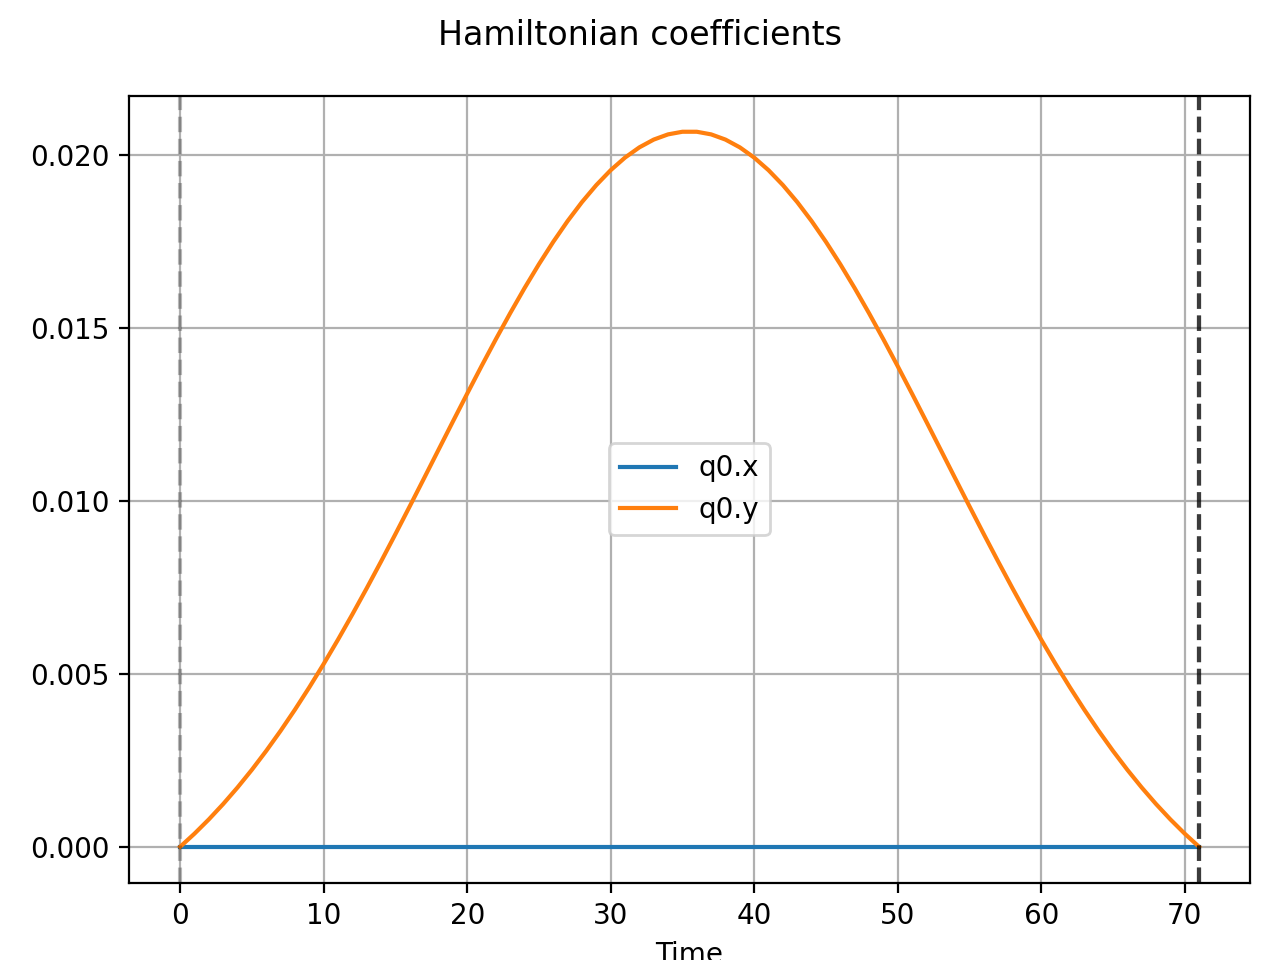

In [5]:
_ = seq.plot_coefficients(subplots=False)

result = seq.run(qreg.ground_state())

Note that the dashed vertical lines above indicate times at which instantaneous unitary operation(s) occur in the sequence. Darker dashed lines indicate multiple unitaries occur at that point in time.

In [6]:
def bell_state(qreg):
    zeros = [0] * len(qreg.active_modes)
    ones = [1] * len(qreg.active_modes)
    return (qreg.logical_basis(*zeros) + qreg.logical_basis(*ones)).unit()

ideal_state = bell_state(qreg)
display(result.states[-1])
display(ideal_state)

fidelity = qutip.fidelity(result.states[-1], ideal_state)**2
print(f'Bell state fidelity: {fidelity:.7f}')

Quantum object: dims = [[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape = (32, 1), type = ket
Qobj data =
[[0.70712164]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70709193]]

Quantum object: dims = [[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape = (32, 1), type = ket
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]]

Bell state fidelity: 1.0000000


In [7]:
creg = seq.measure(result.states[-1])
print('All qubits are entangled, so we gain no information by measuring any of them individually:')
print('\n\t[' + ', '.join([f'{c:.4f}' for c in creg]) + ']')

All qubits are entangled, so we gain no information by measuring any of them individually:

	[0.5000, 0.5000, 0.5000, 0.5000, 0.5000]


In [8]:
print(len(seq))
print(seq[0] == 1j * qubits[-1].Rz(np.pi))
print(isinstance(seq[1], PulseSequence))
print(seq[2] == qreg.I())
print(seq[3] == seq.CX(qubits[-1], qubits[-2], append=False))
print(seq[4] == seq.CX(qubits[-1], qubits[-3], append=False))
print(seq[5] == seq.CX(qubits[-1], qubits[-4], append=False))
print(seq[6] == seq.CX(qubits[-1], qubits[-5], append=False))

7
True
True
True
True
True
True
True


### Using `QasmSequence` gates directly

In [9]:
seq = QasmSequence(qreg)

seq.h(qubits[-1], unitary=False)
seq.barrier()
for q in qubits[:-1]:
    seq.CX(qubits[-1], q)
seq.gphase(np.pi/2)

<IPython.core.display.Javascript object>


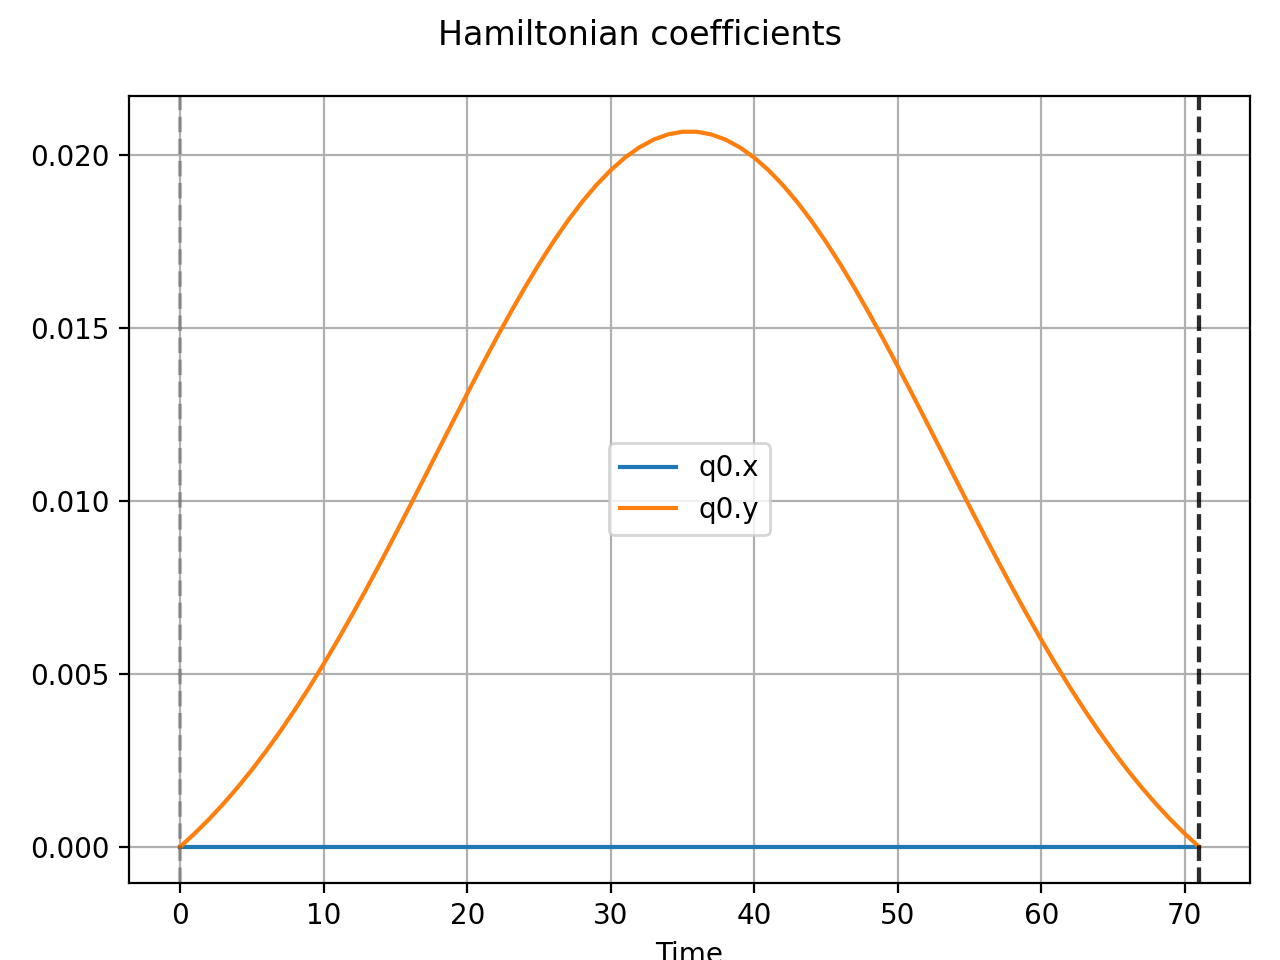

In [10]:
_ = seq.plot_coefficients(subplots=False)

result = seq.run(qreg.ground_state())

In [11]:
ideal_state = bell_state(qreg)
display(result.states[-1])
display(ideal_state)

fidelity = qutip.fidelity(result.states[-1], ideal_state)**2
print(f'Bell state fidelity: {fidelity:.7f}')

Quantum object: dims = [[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape = (32, 1), type = ket
Qobj data =
[[0.70712164]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70709193]]

Quantum object: dims = [[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape = (32, 1), type = ket
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]]

Bell state fidelity: 1.0000000


## Bernstein-Vazirani

See [Bernstein-Vazirani](https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html) for the Qiskit implementation of this algorithm.

In [12]:
def bernstein_vazirani(qreg, secret, unitary=False):
    """Performs the Bernstein-Vazirani algorithm
    on a register of qubits. The qubit indexed -1 is
    used as the ancilla.
    """
    if len(secret) != len(qreg.active_modes) - 1:
        raise ValueError(
            'The secret string must have one fewer bits '
            'than the qubit register has qubits.'
        )
    seq = QasmSequence(qreg)
    ancilla = qreg.active_modes[-1]
    register = qreg.active_modes[:-1]

    # Apply Hadamard gates before querying the oracle
    for q in register + [ancilla]:
        seq.h(q, unitary=unitary)

    # put ancilla in state |->       
    seq.barrier()
    seq.z(ancilla)
    seq.barrier()
    
    for q, s in zip(register, secret):
        if s == '0':
            seq.id(q, unitary=True)
        else:
            seq.CX(q, ancilla)
            
    seq.barrier()

    # Apply Hadamard gates after querying the oracle
    for q in register:
        seq.h(q, unitary=unitary)
        
    result = seq.run(qreg.ground_state())
    return seq, result.states

<IPython.core.display.Javascript object>


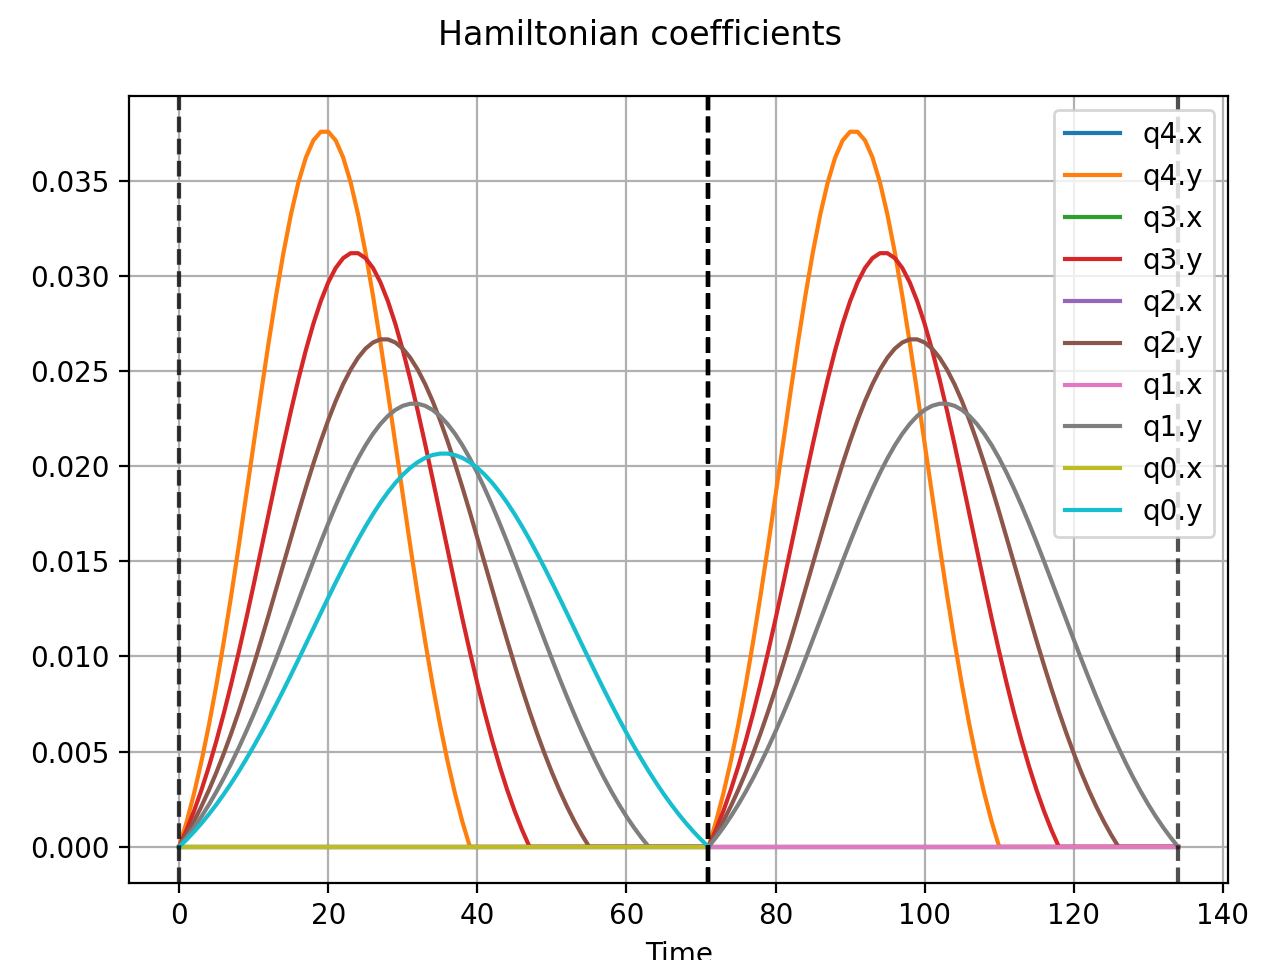

In [13]:
secret = '0101'   # the hidden binary string
seq, states = bernstein_vazirani(qreg, secret, unitary=False)
_ = seq.plot_coefficients(subplots=False)

In [14]:
# Perform a measurement in the logical basis
# on all qubits other than the ancilla
creg = seq.measure(states[-1], *qreg.active_modes[:-1])
print('[' + ', '.join([f'{c:.4f}' for c in creg]) + ']')

[0.0000, 1.0000, 0.0000, 1.0000]


<IPython.core.display.Javascript object>


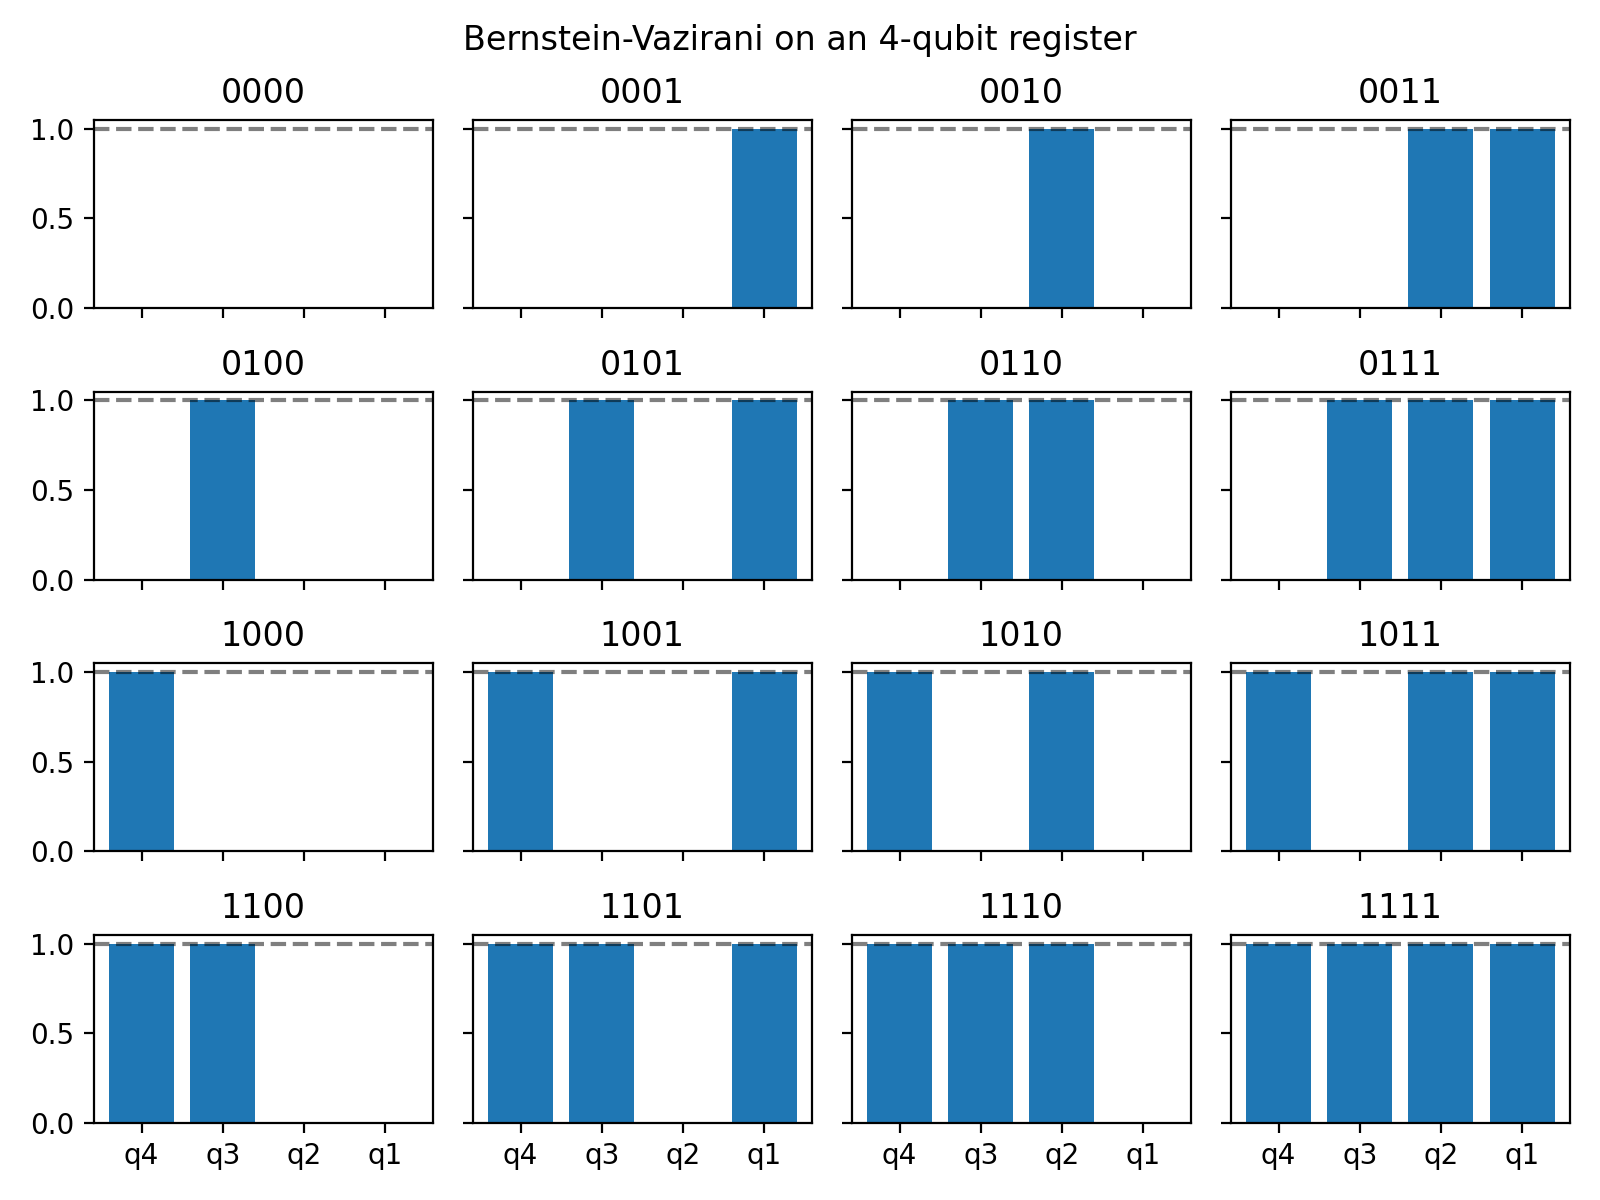

In [15]:
import itertools
# all bitstrings of length n-1
bitstrings = [''.join(seq) for seq in itertools.product('01', repeat=(n-1))]

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8,6))

register = qreg.active_modes[:-1]
measurement_results = []
for secret, ax in zip(bitstrings, axes.flat):
    # execute the sequence
    _, states = bernstein_vazirani(qreg, secret, unitary=True)
    # perform measurements
    labels = [f'q{n-1-q.index}' for q in register]
    creg = seq.measure(states[-1], *qubits[:-1])
    measurement_results.append(creg)
    # plot the results
    ax.bar(labels, creg)
    ax.axhline(1, color='k', ls='--', alpha=0.5)
    ax.set_xticks(labels)
    ax.set_title(secret)
fig.suptitle(f'Bernstein-Vazirani on an {n-1}-qubit register')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
measurement_results = np.array(measurement_results)

In [16]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.5.2
Numpy,1.19.2
SciPy,1.5.2
matplotlib,3.2.2
Cython,0.29.21
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,7.19.0
Python,"3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]"
OS,nt [win32]
